# Project 2

In [1]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble as ens
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from torch import nn
from skorch import NeuralNetClassifier
import datetime
from datetime import date, timedelta
import calendar  # Ahh, importing the weekdays

In [2]:
# Import data from .csv file
traffic_data = pd.read_csv("data.csv")

print(traffic_data)
print ('Unique values of month:',traffic_data.Måned.unique())
print ('Unique values of hour:',traffic_data.Fra_time.unique())

         År  Måned  Dag  Fra_time  Volum til SNTR  Volum til DNP  Volum totalt
0      2015     12   16        11             265            232           497
1      2015     12   16        12             243            223           466
2      2015     12   16        13             251            289           540
3      2015     12   16        14             369            409           778
4      2015     12   16        15             283            365           648
...     ...    ...  ...       ...             ...            ...           ...
35187  2019     12   31        19              77             72           149
35188  2019     12   31        20              58             61           119
35189  2019     12   31        21              52             51           103
35190  2019     12   31        22              51             39            90
35191  2019     12   31        23              34             81           115

[35192 rows x 7 columns]
Unique values of month: [1

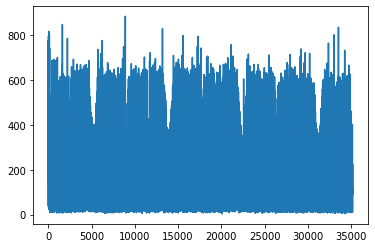

In [3]:
# Plot all the total traffic per hour over time to give a holitic impression of the data
y_volum_totalt = traffic_data['Volum totalt']
y = y_volum_totalt
x = list(range(0, len(y_volum_totalt)))

plt.plot(x, y)
plt.show()
#It looks like there is a tendency for the traffic to slow down at around the same time each year

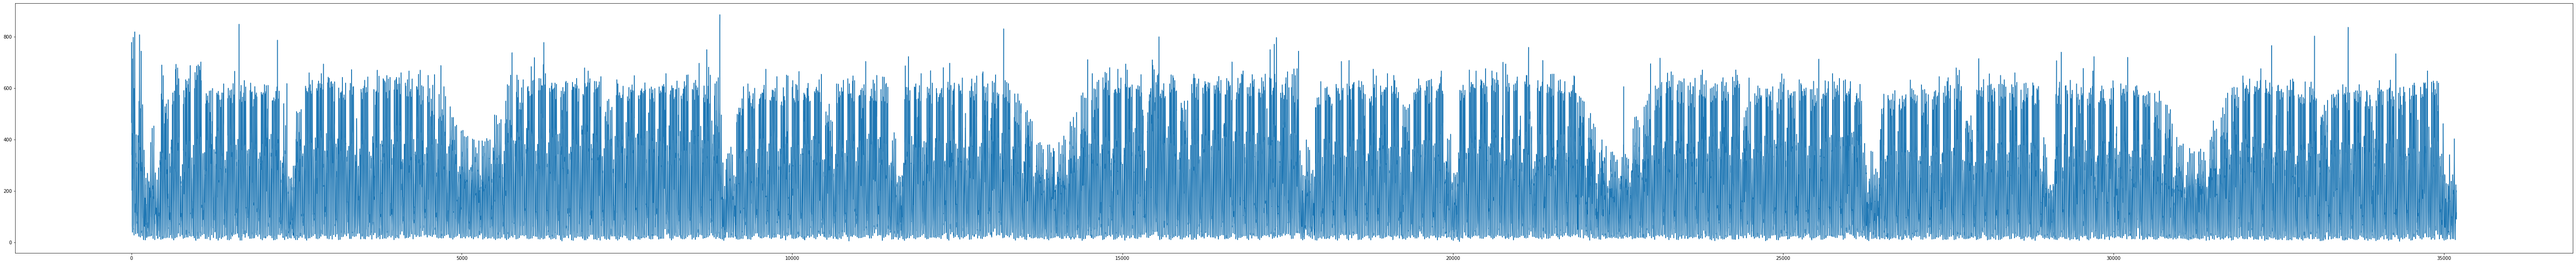

In [4]:
fig = plt.figure(figsize=(100,10))
plt.plot(x, y)
plt.show()
#If we spread out the data a bit more it also seems like there is a repetition of patterns every week

In [5]:
#Let us have a look at the individual years
year_2015 = traffic_data[traffic_data['År'] == 2015]
year_2016 = traffic_data[traffic_data['År'] == 2016]
year_2017 = traffic_data[traffic_data['År'] == 2017]
year_2018 = traffic_data[traffic_data['År'] == 2018]
year_2019 = traffic_data[traffic_data['År'] == 2019]

print("Length of data from 2015:", len(year_2015))
print("Length of data from 2016:", len(year_2016))
print("Length of data from 2017:", len(year_2017))
print("Length of data from 2018:", len(year_2018))
print("Length of data from 2019:", len(year_2019))

Length of data from 2015: 373
Length of data from 2016: 8758
Length of data from 2017: 8760
Length of data from 2018: 8545
Length of data from 2019: 8756


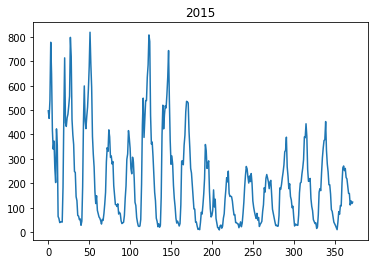

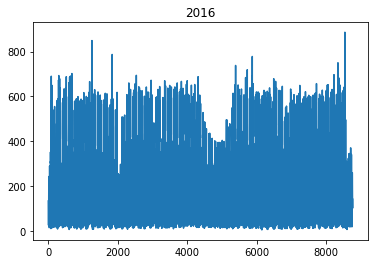

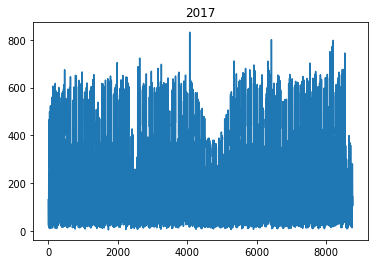

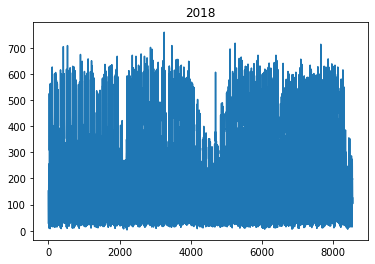

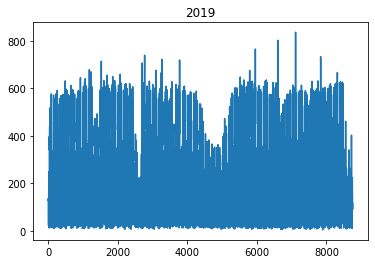

In [6]:
#We can see that the data size is not identical for each year, ie we don't have a value for the traffic at every hour for every year.
#However 2016-2019 seem to have about the same amount of data
x_2015 = list(range(0, len(year_2015)))
y_2015 = year_2015['Volum totalt']
plt.plot(x_2015,y_2015)
plt.title("2015")
plt.show()

x_2016 = list(range(0, len(year_2016)))
y_2016 = year_2016['Volum totalt']
plt.plot(x_2016,y_2016)
plt.title("2016")
plt.show()

x_2017 = list(range(0, len(year_2017)))
y_2017 = year_2017['Volum totalt']
plt.plot(x_2017,y_2017)
plt.title("2017")
plt.show()

x_2018 = list(range(0, len(year_2018)))
y_2018 = year_2018['Volum totalt']
plt.plot(x_2018,y_2018)
plt.title("2018")
plt.show()

x_2019 = list(range(0, len(year_2019)))
y_2019 = year_2019['Volum totalt']
plt.plot(x_2019,y_2019)
plt.title("2019")
plt.show()

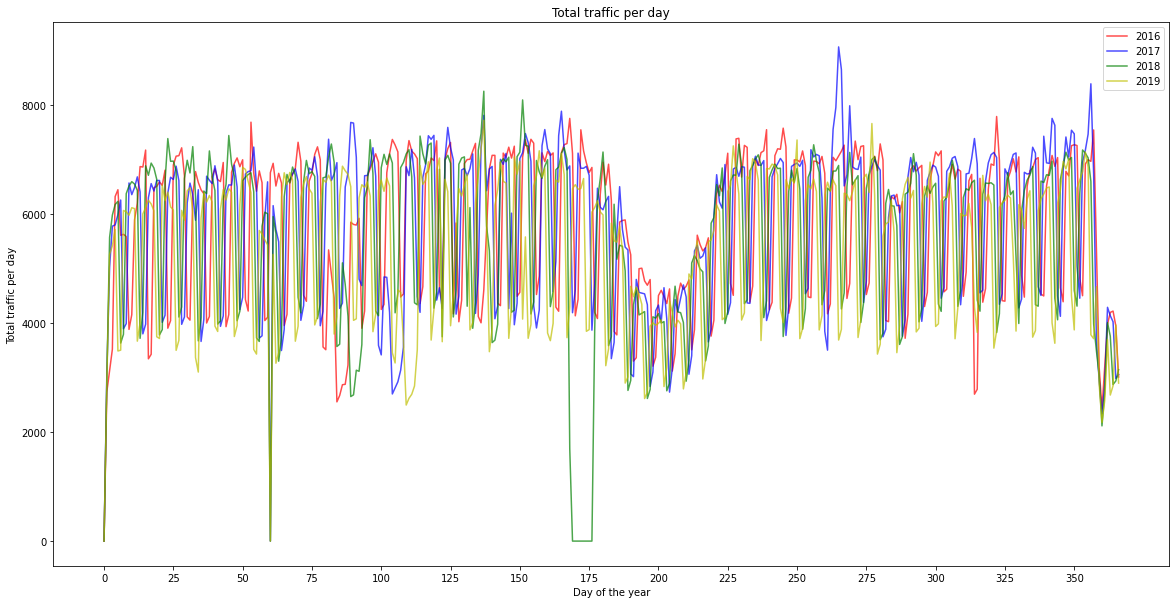

In [7]:
#Since it is a bit difficult to tell the average traffic per day with the data represented like this, we can try to get total traffic per day instead of per hour

def get_total_traffic_per_day(traffic_data):
    """
    Gernerates a list of total traffic per day, where the index corresponds to the day number +1.
    
    :param traffic_data: dataframe of traffic data, or a subset of the dataframe (fex data for a year)
    """
    totat_traffic_per_day = np.ones(367)
    for i in range(len(traffic_data)):
        hour_datapoint = traffic_data.iloc[i]
        month_number = hour_datapoint[1]
        day_number = hour_datapoint[2]
        day_of_the_year = datetime.datetime(2016, month_number, day_number).timetuple().tm_yday #retrieve day number
        totat_traffic_per_day[day_of_the_year] += hour_datapoint[6] #add traffic that hour to the total traffic per day
    return totat_traffic_per_day

#generate lists of total traffic per day for the years
total_traffic_per_day_2016 = get_total_traffic_per_day(year_2016)
total_traffic_per_day_2017 = get_total_traffic_per_day(year_2017)
total_traffic_per_day_2018 = get_total_traffic_per_day(year_2018)
total_traffic_per_day_2019 = get_total_traffic_per_day(year_2019)

x_days_total = list(range(0, len(total_traffic_per_day_2016)))


#plotting the traffic pr day
fig = plt.figure(figsize=(20,10))
plt.plot(x_days_total,total_traffic_per_day_2016, 'r-', alpha = 0.7, label = "2016")
plt.plot(x_days_total,total_traffic_per_day_2017, 'b-', alpha = 0.7, label = "2017")
plt.plot(x_days_total,total_traffic_per_day_2018, 'g-', alpha = 0.7, label = "2018")
plt.plot(x_days_total,total_traffic_per_day_2019, 'y-', alpha = 0.7, label = "2019")
plt.title("Total traffic per day")
plt.xticks(np.arange(min(x_days_total), max(x_days_total)+1, 25))
plt.xlabel("Day of the year")
plt.ylabel("Total traffic per day")
plt.legend()
plt.show()

While we can se a consistent trend, we would like to extract a bit more information from the data, such as the day of the year and what weekday each datapoint has. Therefore we construct a list of the traffic data represented in datetime format.

In [8]:
datetime_representation_of_today = datetime.datetime.today()
print("Datetime representation of today:", datetime_representation_of_today)

#initialize np array to store datetime of each datapoint in traffic_data
traffic_data_datetime = np.full(len(traffic_data), datetime_representation_of_today)
for i in range(len(traffic_data)):
    data_point = traffic_data.iloc[i]
    datetime_representation_of_datapoint = datetime.datetime(data_point[0], data_point[1], data_point[2],data_point[3])
    traffic_data_datetime[i] = datetime_representation_of_datapoint
print("Datetime represenation of traffic data:")
print(traffic_data_datetime)

Datetime representation of today: 2020-10-07 21:34:57.804683
Datetime represenation of traffic data:
[datetime.datetime(2015, 12, 16, 11, 0)
 datetime.datetime(2015, 12, 16, 12, 0)
 datetime.datetime(2015, 12, 16, 13, 0) ...
 datetime.datetime(2019, 12, 31, 21, 0)
 datetime.datetime(2019, 12, 31, 22, 0)
 datetime.datetime(2019, 12, 31, 23, 0)]


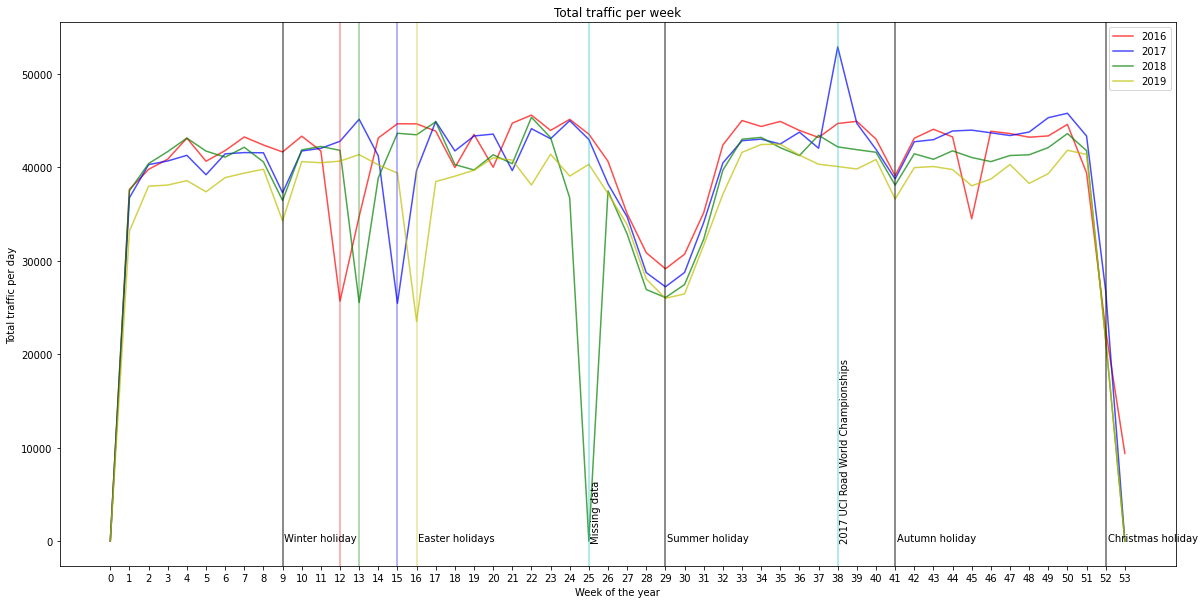

In [9]:
#It is still a bit distracting to see the fluctuation between weekends and weekdays, so we'll take total traffic per week

def get_total_traffic_per_week(traffic_data):
    """
    Gernerates a list of total traffic per day, where the index corresponds to the day number +1.
    
    :param traffic_data: dataframe of traffic data, or a subset of the dataframe (fex data for a year)
    """
    total_traffic_per_week = np.ones(54)
    for i in range(len(traffic_data)):
        hour_datapoint = traffic_data.iloc[i]
        year_number = hour_datapoint[0]
        month_number = hour_datapoint[1]
        day_number = hour_datapoint[2]
        week_number = datetime.datetime(year_number, month_number, day_number).isocalendar()[1]
        total_traffic_per_week[week_number] += hour_datapoint[6] #add traffic that hour to the total traffic per day
    return total_traffic_per_week

#generate lists of total traffic per day for the years
total_traffic_per_week_2016 = get_total_traffic_per_week(year_2016)
total_traffic_per_week_2017 = get_total_traffic_per_week(year_2017)
total_traffic_per_week_2018 = get_total_traffic_per_week(year_2018)
total_traffic_per_week_2019 = get_total_traffic_per_week(year_2019)


x_value_weeks_total = list(range(0, len(total_traffic_per_week_2016)))

#plotting the traffic pr day
fig = plt.figure(figsize=(20,10))
plt.plot(x_value_weeks_total,total_traffic_per_week_2016, 'r-', alpha = 0.7, label = "2016")
plt.plot(x_value_weeks_total,total_traffic_per_week_2017, 'b-', alpha = 0.7, label = "2017")
plt.plot(x_value_weeks_total,total_traffic_per_week_2018, 'g-', alpha = 0.7, label = "2018")
plt.plot(x_value_weeks_total,total_traffic_per_week_2019, 'y-', alpha = 0.7, label = "2019")

# Marking seasonal holidays
plt.axvline(x=9, ymin=0, ymax=60000, color = 'k',alpha = 0.6)
plt.text(9.1,0,'Winter holiday')
plt.axvline(x=41, ymin=0, ymax=60000, color = 'k', alpha = 0.6)
plt.text(41.1,0,'Autumn holiday')
plt.axvline(x=52, ymin=0, ymax=60000, color = 'k', alpha = 0.6)
plt.text(52.1,0,'Christmas holiday')
plt.axvline(x=29, ymin=0, ymax=60000, color = 'k', alpha = 0.6)
plt.text(29.1,0,'Summer holiday')

# Marking easter holidays
plt.axvline(x=12, ymin=0, ymax=60000, color = 'r', alpha = 0.4)
plt.axvline(x=13, ymin=0, ymax=60000, color = 'g', alpha = 0.4)
plt.axvline(x=15, ymin=0, ymax=60000, color = 'b', alpha = 0.4)
plt.axvline(x=16, ymin=0, ymax=60000, color = 'y', alpha = 0.4)
plt.text(16.1,0,'Easter holidays')

# Marking outlier
plt.axvline(x=38, ymin=0, ymax=60000, color = 'c', alpha = 0.4)
plt.text(38.1, 0, "2017 UCI Road World Championships", rotation = "90")
# Marking outlier
plt.axvline(x=25, ymin=0, ymax=60000, color = 'c', alpha = 0.4)
plt.text(25.1, 0, "Missing data", rotation = "90")


# Adding labels
plt.xticks(np.arange(min(x_value_weeks_total), max(x_value_weeks_total)+1, 1))
plt.xlabel("Week of the year")
plt.ylabel("Total traffic per day")
plt.title("Total traffic per week")
plt.legend()
plt.show()

The black vertical lines represent condistent holidays that appear to fall on the same time every year. Unfortunately easter falls on different weeks every year, but we will mark then as "holiday" too. There is some data missing around week 25, but this has no effect even though it looks like it on the graph. Had the graph represented "average traffic per week" there would be no dip in traffic. 

In week 38 in 2017, however, there was a big sports event in Bergen, so this is a true outlier which will have an effect on the model.

Overall we can see that the week number has a lot to say for the fluctuation of data, so we could add it to the list of features.

In [10]:
##### Adding holiday feature to data #####

#First we want to make a list of days that we define as "holiday days". We will base this on the holidays identified in the graph above.
holiday_dates = []

#Some helper functions
def getDateRangeFromWeek(p_year,p_week): #sauce: http://mvsourcecode.com/python-how-to-get-date-range-from-week-number-mvsourcecode/
    firstdayofweek = datetime.datetime.strptime(f'{p_year}-W{int(p_week )- 1}-1', "%Y-W%W-%w").date()
    lastdayofweek = firstdayofweek + datetime.timedelta(days=6.9)
    return firstdayofweek, lastdayofweek

def extract_holiday_dates(holdiday_year, holiday_week): #sauce: https://stackoverflow.com/questions/7274267/print-all-day-dates-between-two-dates
    holiday_dates = np.full(7, datetime_representation_of_today) #initialize list to store holiday dated
    firstdate, lastdate =  getDateRangeFromWeek(holdiday_year,holiday_week)
    delta =  lastdate - firstdate       # as timedelta
    for i in range(delta.days + 1):
        holiday_day = firstdate + timedelta(days=i)
        holiday_dates[i] = holiday_day
    return holiday_dates

# The week number of holidays is based on information from Bergen Kommune, timeanddate.no and the graph above
winter_holiday_week_number = 9
summer_holiday_week_number_range = list(range(26, 33))
autumn_holiday_week_number = 41
christmas_holiday_week_number_range = list(range(52, 54))

# Add the holiday dates for years 2015-2019
for year in range(2015, 2020):
    winter_holiday_dates = extract_holiday_dates(year, winter_holiday_week_number)
    autumn_holiday_dates = extract_holiday_dates(year, autumn_holiday_week_number)

    summer_holiday_dates = []
    for week in summer_holiday_week_number_range:
        new_summer_holiday_dates = extract_holiday_dates(year, week)
        summer_holiday_dates = np.concatenate([summer_holiday_dates, new_summer_holiday_dates])

    christmas_holiday_dates = []
    for week in christmas_holiday_week_number_range:
        new_christmas_holiday_dates = extract_holiday_dates(year, week)
        christmas_holiday_dates = np.concatenate([christmas_holiday_dates, new_christmas_holiday_dates])

    holiday_dates = np.concatenate([holiday_dates, winter_holiday_dates, summer_holiday_dates, autumn_holiday_dates, christmas_holiday_dates]) # add holiday dates for the year

holiday_dates = np.concatenate([holiday_dates,
[datetime.date(2015, 12, 28), datetime.date(2015, 12, 29), datetime.date(2015, 12, 30),
 datetime.date(2015, 12, 31), datetime.date(2016, 1, 1), datetime.date(2016, 12, 26),
 datetime.date(2016, 12, 27), datetime.date(2016, 12, 28), datetime.date(2016, 12, 29),
 datetime.date(2016, 12, 30), datetime.date(2016, 12, 31), datetime.date(2017, 1, 1),
 datetime.date(2018, 1, 1), datetime.date(2018, 12, 31), datetime.date(2019, 1, 1),
 datetime.date(2019, 12, 30), datetime.date(2019, 12, 31)]])

# Add the easter weeks separately, as the week of the holiday varies from year to year
holiday_dates = np.concatenate([holiday_dates, 
                                extract_holiday_dates(2016, 13), # dates for easter 2016
                                extract_holiday_dates(2017, 16), # dates for easter 2017
                                extract_holiday_dates(2018, 14), # dates for easter 2018
                                extract_holiday_dates(2019, 16)]) # dates for easter 2019


#Now we have a list of holiday dates, and can generate a hot-one encoded feature array for the dataset.

is_holiday = np.zeros(len(traffic_data)) #Feature array for holidays. 1 if the datapoint is in a holiday, 0 otherwise

#This is a brute force method, which definitely could be improved upon
for i in range(len(traffic_data_datetime)):
    for holiday_date in holiday_dates:
        if traffic_data_datetime[i].date() == holiday_date:
            is_holiday[i] = 1
            continue

traffic_data['is_holiday'] = is_holiday #add "is_holiday" column to traffic_data dataframe

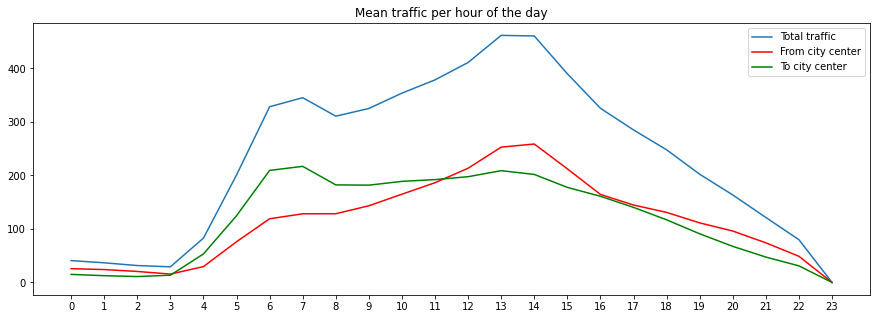

In [11]:
#Now let us look at the traffic for each hour of the day, and compare the traffic in and out of town
y_volum_til_DNP = traffic_data['Volum til DNP']
y_volum_til_SNTR = traffic_data['Volum til SNTR']
volum_totalt = traffic_data['Volum totalt']

x_hour_total = list(range(0, 24))
y_hour_total = np.zeros(24)
for i in range(0, 23):
    traffic_per_hour_i = traffic_data[traffic_data['Fra_time'] == i]
    mean_pr_hour = np.mean(traffic_per_hour_i['Volum totalt'])
    y_hour_total[i] = mean_pr_hour

x_hour_to_DNP = list(range(0, 24))
y_hour_to_DNP = np.zeros(24)
for i in range(0, 23):
    traffic_per_hour_i = traffic_data[traffic_data['Fra_time'] == i]
    mean_pr_hour = np.mean(traffic_per_hour_i['Volum til DNP'])
    y_hour_to_DNP[i] = mean_pr_hour

x_hour_to_SNTR = list(range(0, 24))
y_hour_to_SNTR = np.zeros(24)
for i in range(0, 23):
    traffic_per_hour_i = traffic_data[traffic_data['Fra_time'] == i]
    mean_pr_hour = np.mean(traffic_per_hour_i['Volum til SNTR'])
    y_hour_to_SNTR[i] = mean_pr_hour

fig = plt.figure(figsize=(15,5))
plt.plot(x_hour_total,y_hour_total, label ="Total traffic")
plt.plot(x_hour_to_DNP,y_hour_to_DNP, c = 'r', label ="From city center")
plt.plot(x_hour_to_SNTR,y_hour_to_SNTR, c = 'g', label = "To city center")
plt.title("Mean traffic per hour of the day")
plt.xticks(np.arange(min(x_hour_total), max(x_hour_total)+1, 1.0))
plt.legend()
plt.show()


We want to convey the cyclic nature of the hours of the day, and unfortunately the way the hours are represented now gives no indication that the 23rd hour is close to the 0th hour. To solve this we will use two triginometric functions sin((2t*pi)/24) and sin((2t*pi)/24), where t is the hour of the day. We add two features one with sin and the other with cos, because if we only used one of the two, then two hours in the day would have the exact same value, indicating a relationship where there is none.

We do the same with days of the year.

In [12]:
#first we generate a list values for the two functions, so we can just retrieve the values instead of calculate them each time.

sin_hour_values = np.ones(24)
cos_hour_values = np.ones(24)
sin_day_values = np.ones(367)
cos_day_values = np.ones(367) #need to accustom to leap years
# fill in lists of sin and cos values
for h in range(24):
    sin_hour_values[h] = np.sin((2*h*np.pi) / 24)
    cos_hour_values[h] = np.cos((2*h*np.pi) / 24)   
for d in range(367):
    sin_day_values[d] = np.sin((2*np.pi*d) / 367)
    cos_day_values[d] = np.cos((2*np.pi*d) / 367)

#initialize new feature columns
sin_hour = np.zeros(len(traffic_data)) 
cos_hour = np.zeros(len(traffic_data)) 
sin_day = np.zeros(len(traffic_data)) 
cos_day = np.zeros(len(traffic_data)) 

#Iterate through all the data, and add the correspongind sin and cos values to the feature columns
for i in range(len(traffic_data_datetime)):
    #retrieve hour and day nukber
    hour_of_datapoint = traffic_data_datetime[i].hour
    day_of_datapoint = traffic_data_datetime[i].timetuple().tm_yday
    sin_hour[i] = sin_hour_values[hour_of_datapoint]
    cos_hour[i] = cos_hour_values[hour_of_datapoint]
    sin_day[i] = sin_day_values[day_of_datapoint]
    cos_day[i] = cos_day_values[day_of_datapoint]

traffic_data['sin_hour'] = sin_hour #add sin_hour column to traffic_data dataframe
traffic_data['cos_hour'] = cos_hour
traffic_data['sin_day'] = sin_day
traffic_data['cos_day'] = cos_day

[662138.0, 687519.0, 686097.0, 683619.0, 678764.0, 397095.0, 402330.0]
[626696.0, 650963.0, 656129.0, 661215.0, 648333.0, 422933.0, 441949.0]
[1288834.0, 1338482.0, 1342226.0, 1344834.0, 1327097.0, 820028.0, 844279.0]


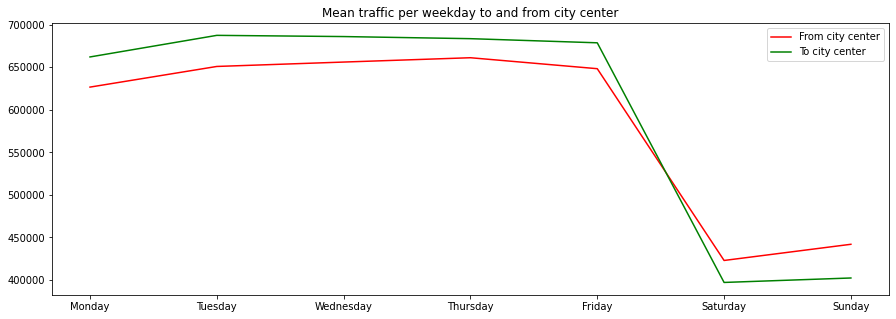

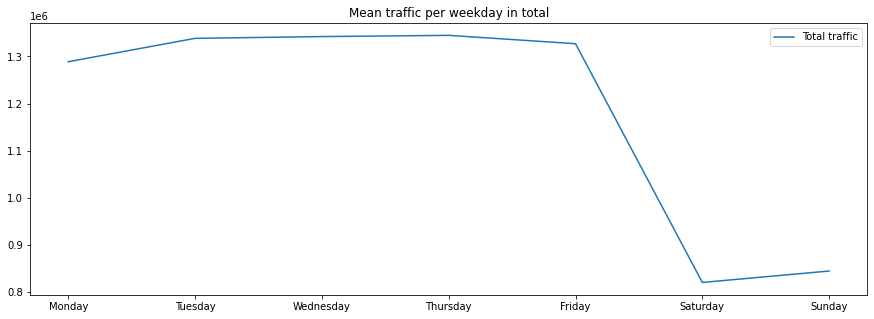

In [13]:
weekdays_to_SNTR = [0]*7
weekdays_to_DNP = [0]*7
weekdays_total = [0]*7
is_weekend = []

for i in range(len(traffic_data)):
    data_point = traffic_data.iloc[i]
    weekday = traffic_data_datetime[i].weekday()
    is_weekend.append(int(weekday > 4))  # Adding to one-hot "isWeekend"
    weekdays_to_SNTR[weekday] += data_point[4]
    weekdays_to_DNP[weekday] += data_point[5]
    weekdays_total[weekday] += data_point[6]

print(weekdays_to_SNTR)
print(weekdays_to_DNP)
print(weekdays_total)

day_names = list(calendar.day_name)
fig = plt.figure(figsize=(15,5))
plt.plot(day_names, weekdays_to_DNP, c = 'r', label ="From city center")
plt.plot(day_names, weekdays_to_SNTR, c = 'g', label = "To city center")
plt.title("Mean traffic per weekday to and from city center")
plt.legend()
plt.show()

day_names = list(calendar.day_name)
fig = plt.figure(figsize=(15,5))
plt.plot(day_names, weekdays_total, label ="Total traffic")
plt.title("Mean traffic per weekday in total")
plt.legend()
plt.show()
#TODO: implement one-hot encoding for months and days. Those values have very little to do with each other

In [14]:
traffic_data['is_weekend'] = is_weekend #add "is_weekend" column to traffic_data dataframe
#DST = daylight saving time
#Generate a column for the DST feature, with 1 indicating the datapoint is in DST, and 0 if it is not
DST = []
DST_switch = False
for i in range(len(traffic_data)):
    data_point = traffic_data.iloc[i]
    # TODO: Abstract/refactor the line under
    if data_point[0] == 2016 and data_point[1] == 3 and data_point[2] == 27 and data_point[3] == 2:
        DST_switch = True
    elif data_point[0] == 2016 and data_point[1] == 10 and data_point[2] == 30 and data_point[3] == 3:
        DST_switch = False
    elif data_point[0] == 2017 and data_point[1] == 3 and data_point[2] == 26 and data_point[3] == 2:
        DST_switch = True
    elif data_point[0] == 2017 and data_point[1] == 10 and data_point[2] == 29 and data_point[3] == 3:
        DST_switch = False
    elif data_point[0] == 2018 and data_point[1] == 3 and data_point[2] == 25 and data_point[3] == 2:
        DST_switch = True
    elif data_point[0] == 2018 and data_point[1] == 10 and data_point[2] == 28 and data_point[3] == 3:
        DST_switch = False
    elif data_point[0] == 2019 and data_point[1] == 3 and data_point[2] == 31 and data_point[3] == 2:
        DST_switch = True
    elif data_point[0] == 2019 and data_point[1] == 10 and data_point[2] == 27 and data_point[3] == 3:
        DST_switch = False
    DST.append(int(DST_switch))

traffic_data['is_DST'] = DST #add DST column to traffic_data dataframe

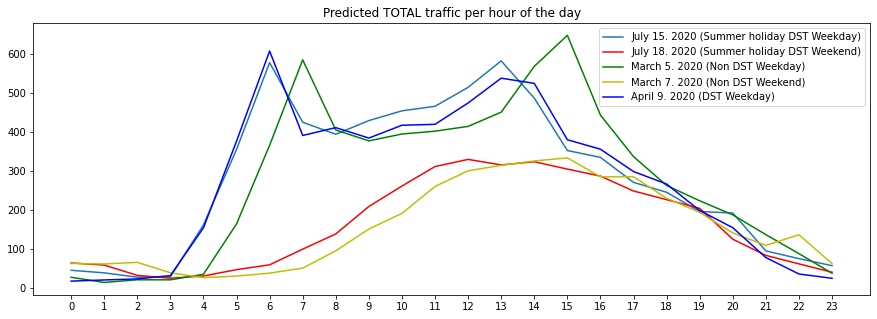

In [15]:
################### Learning ###############

### Total traffic experiment
x = traffic_data[["År", "Måned", "Dag", "Fra_time", "is_weekend", "is_DST", "is_holiday"]].values
y = traffic_data["Volum totalt"].values
test_1 = []
test_2 = []
test_3 = []
test_4 = []
test_5 = []
for i in range(24):
    test_1.append([2020, 7, 15, i, 0, 1, 0])
    test_2.append([2020, 7, 18, i, 1, 1, 0])
    test_3.append([2020, 3, 5, i, 0, 0, 0])
    test_4.append([2020, 3, 7, i, 1, 0, 0])
    test_5.append([2020, 4, 9, i, 0, 1, 0])

forest = ens.RandomForestRegressor()
forest.fit(x, y)
result_1 = forest.predict(test_1)
result_2 = forest.predict(test_2)
result_3 = forest.predict(test_3)
result_4 = forest.predict(test_4)
result_5 = forest.predict(test_5)

fig = plt.figure(figsize=(15,5))
x_hour = list(range(24))
plt.plot(x_hour, result_1, label ="July 15. 2020 (Summer holiday DST Weekday)")
plt.plot(x_hour, result_2, c = 'r', label ="July 18. 2020 (Summer holiday DST Weekend)")
plt.plot(x_hour, result_3, c = 'g', label = "March 5. 2020 (Non DST Weekday)")
plt.plot(x_hour, result_4, c = 'y', label = "March 7. 2020 (Non DST Weekend)")
plt.plot(x_hour, result_5, c = 'b', label = "April 9. 2020 (DST Weekday)")
plt.title("Predicted TOTAL traffic per hour of the day")
plt.xticks(np.arange(min(x_hour_total), max(x_hour_total)+1, 1.0))
plt.legend()
plt.show()

In [16]:
#Use TimeSeriesSplit to split the data into train and test to get accuracies
#TODO: split into train, validate, test. We have only split into train/test so far
X = traffic_data[["År", "Måned", "Dag", "Fra_time", "sin_hour", "cos_hour", "sin_day", "cos_day", "is_holiday", "is_weekend", "is_DST"]].values

y = traffic_data["Volum totalt"].values

number_of_splits = 5
tscv = TimeSeriesSplit(number_of_splits)


print("###\tRandom Forest\t###\nTotal number of splits:", number_of_splits)
split_number = 1

list_of_coefficients_of_determination = [] #list to keep track of coefficients of determination
for train_index, test_index in tscv.split(X):
    print("Split number:", split_number)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    forest = ens.RandomForestRegressor()
    forest.fit(X_train,  y_train)
    forest_predict = forest.predict(X_test) 
    #forest_MSE = mean_squared_error(y_test, forest_predict)
    print("Mean Square Error: %.2f" %mean_squared_error(y_test, forest_predict))
    coefficient_of_determination = r2_score(y_test, forest_predict)
    list_of_coefficients_of_determination.append(coefficient_of_determination)
    print('Coefficient of determination: %.2f' %coefficient_of_determination)
    split_number += 1    
    print("")
print('Mean coefficient of determination: %.2f' %np.mean(list_of_coefficients_of_determination)) #might  be some sklearn function that does this for us



print("\n\n###\tRegression Decision Tree\t###\nTotal number of splits:", number_of_splits)
split_number = 1

list_of_coefficients_of_determination = [] #list to keep track of coefficients of determination
for train_index, test_index in tscv.split(X):
    print("Split number:", split_number)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    tree = DecisionTreeRegressor(max_depth=10)
    tree.fit(X_train,  y_train)
    tree_predict = tree.predict(X_test)
    #tree_MSE = mean_squared_error(y_test, tree_predict)
    print("Mean Square Error: %.2f" %mean_squared_error(y_test, tree_predict))
    coefficient_of_determination = r2_score(y_test, tree_predict)
    list_of_coefficients_of_determination.append(coefficient_of_determination)
    print('Coefficient of determination: %.2f' %coefficient_of_determination)
    split_number += 1
    print("")
print('Mean coefficient of determination: %.2f' %np.mean(list_of_coefficients_of_determination)) #might  be some sklearn function that does this for us

###	Random Forest	###
Total number of splits: 5
Split number: 1
Mean Square Error: 3780.33
Coefficient of determination: 0.88

Split number: 2
Mean Square Error: 2448.01
Coefficient of determination: 0.92

Split number: 3
Mean Square Error: 2366.66
Coefficient of determination: 0.92

Split number: 4
Mean Square Error: 2127.85
Coefficient of determination: 0.93

Split number: 5
Mean Square Error: 1952.81
Coefficient of determination: 0.93

Mean coefficient of determination: 0.92


###	Regression Decision Tree	###
Total number of splits: 5
Split number: 1
Mean Square Error: 5280.39
Coefficient of determination: 0.83

Split number: 2
Mean Square Error: 2542.65
Coefficient of determination: 0.92

Split number: 3
Mean Square Error: 2621.15
Coefficient of determination: 0.91

Split number: 4
Mean Square Error: 2512.61
Coefficient of determination: 0.92

Split number: 5
Mean Square Error: 1973.45
Coefficient of determination: 0.93

Mean coefficient of determination: 0.90


In [29]:
print("\n\n###\tNeural Network\t###\nTotal number of splits:", number_of_splits)
split_number = 1

list_of_coefficients_of_determination = [] #list to keep track of coefficients of determination
for train_index, test_index in tscv.split(X):
    print("Split number:", split_number)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Optimal number of neurons should be between 300 and 1500 (one layer is enough, apparently)
    nn = MLPRegressor(hidden_layer_sizes=(300, 300), random_state=1, max_iter=400)  # Default Relu with Adam cost optimizer
    nn.fit(X_train,  y_train)
    nn_predict = nn.predict(X_test)
    #nn_MSE = mean_squared_error(y_test, nn_predict)
    print("Mean Square Error: %.2f" %mean_squared_error(y_test, nn_predict))
    coefficient_of_determination = r2_score(y_test, nn_predict)
    list_of_coefficients_of_determination.append(coefficient_of_determination)
    print('Coefficient of determination: %.2f' %coefficient_of_determination)
    split_number += 1
    print("")
print('Mean coefficient of determination: %.2f' %np.mean(list_of_coefficients_of_determination)) #might  be some sklearn function that does this for us



###	Neural Network	###
Total number of splits: 5
Split number: 1
Mean Square Error: 7667.62
Coefficient of determination: 0.76

Split number: 2
Mean Square Error: 3402.58
Coefficient of determination: 0.89

Split number: 3
Mean Square Error: 3259.92
Coefficient of determination: 0.89

Split number: 4
Mean Square Error: 2605.32
Coefficient of determination: 0.91

Split number: 5
Mean Square Error: 2346.34
Coefficient of determination: 0.92

Mean coefficient of determination: 0.87


We can see that Random Forests has the highest mean coefficient of determination, and will therefore use that as our ML algorithm.
Next step is to predict the traffic coming to Sentrum, and then from Sentrum.

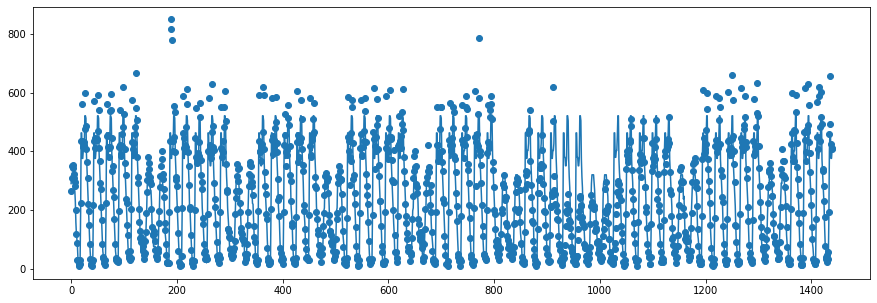

In [17]:
# Regression Decision Tree
days = 60
hours = days * 24
x = traffic_data[["År", "Måned", "Dag", "Fra_time", "is_weekend", "is_DST"]].values
y = traffic_data["Volum totalt"].values

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(x, y)

test_1 = traffic_data[["År", "Måned", "Dag", "Fra_time", "is_weekend", "is_DST"]].values[hours:2*hours]
result_1 = tree.predict(test_1)

fig = plt.figure(figsize=(15,5))
x_hour = list(range(hours))
plt.plot(x_hour, result_1)
plt.scatter(x_hour, traffic_data["Volum totalt"].values[hours:2*hours])
plt.show()
